# Хакатон Open Data Battle (30-31.10.2021)

# Задача по прогнозированию ошибки модели оценки вероятности дефолта (MPP) 

## 1. Описание задачи

Разработана некая базовая модель оценки вероятности дефолта (PD модель). Все работает прекрасно, но нужно контролировать качество этой базовой модели и оценивать ошибку, индуцированную базовой моделью, поэтому нам нужно разработать модель прогнозирования ошибки (MPP). Ошибка в нашем случае - это разница между флагом flg_90_12_add, представляющим собой реализованное событие (0 - не дефолт, 1 - дефолт) и значением PD, представляющим собой оценку от нашей базовой модели.

Таким образом, нам необходимо обучить модель прогнозирования ошибки с использованием двух датасетов и предсказать метрику |PD-flg_90_12_add| для тестовой выборки - тысячи последних экспериментов (incident), где значения PD и flg_90_12_add равны NaN. 

## 2. Исходные данные 

* __data.csv__ — данные об экспериментах (incident), включая большое количество признаков и флаг flg_90_12_add, представляющий собой реализованное событие (0 - не дефолт, 1 - дефолт);
* __model.csv__ — результаты прогнозирования дефолта (PD), полученные в нашей разработанной модели.

В файле __data.csv__ представлены закодированные признаки, как категориальные, так и численные. К сожалению, у нас нет информации, что означает каждый признак, поэтому сразу оценить влияние их на таргет мы не сможем.

## 3. Загрузка и первичный осмотр данных

Для начала работы импортируем все требуемые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor

pd.set_option('display.max_columns',1915)
pd.set_option('display.max_rows',1910)

In [2]:
data = pd.read_csv('/home/an4ouce/Открытие хакатон/data.csv')
model_data = pd.read_csv('/home/an4ouce/Открытие хакатон/model.csv')

In [3]:
data.head()

incident  flg_90_12_add APPLICATION_MONTH  Category_Feature_0  \
0  14511110            0.0           2018-10                 6.0   
1  15018800            0.0           2018-12                 1.0   
2  14499737            0.0           2018-10                 6.0   
3  14953427            0.0           2018-12                 4.0   
4  14744453            0.0           2018-11                 6.0   

   Category_Feature_1  Category_Feature_2  Category_Feature_3  \
0                   2                  25                 2.0   
1                   2                  49                 4.0   
2                   2                  24                 1.0   
3                   2                  26                 1.0   
4                   2                  30                 4.0   

   Category_Feature_4  Category_Feature_5  Category_Feature_6  \
0                 0.0                   3                   1   
1                 0.0                   3                   1   
2                 0.0                   3                   0   
3                 0.0                   3                   1   
4                 2.0                   3                   1   

   Category_Feature_7  Category_Feature_8  Category_Feature_9  \
0                 2.0             35000.0                 0.0   
1                 2.0             50000.0                 0.0   
2                 1.0             20000.0                 0.0   
3                 2.0             30000.0                 0.0   
4                 3.0             50000.0                 0.0   

   Category_Feature_10  Category_Feature_11  Category_Feature_12  \
0                  0.0                  1.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  1.0                  0.0   

   Category_Feature_13  Category_Feature_14  Category_Feature_15  \
0                  2.0                  7.0                  4.0   
1                  2.0                  7.0                  5.0   
2                  NaN                  NaN                  NaN   
3                  2.0                  7.0                  1.0   
4                  2.0                  7.0                  5.0   

   Category_Feature_16  Category_Feature_17  Category_Feature_18  Feature_0  \
0                 28.0                  6.0                  3.0        NaN   
1                 23.0                  3.0                  4.0        NaN   
2                  NaN                  NaN                  NaN        NaN   
3                 32.0                  1.0                  4.0        NaN   
4                 22.0                  5.0                  4.0        NaN   

   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0        NaN        NaN   0.225000   0.175000          0          0   
1        NaN        NaN   0.333333   0.166667          0          0   
2        NaN        NaN   0.253165   0.253165          0          1   
3        NaN        NaN   0.650000   0.150000          0          0   
4        NaN        NaN   0.900000   0.250000          0          1   

   Feature_7  Feature_8  Feature_9  Feature_10  Feature_11  Feature_12  \
0          1          1          0           0           0           1   
1          7          1          0           0           0           4   
2         10          2          2           0           1          10   
3          0          0          0           0           0           0   
4          3          3          0           0           1           3   

   Feature_13  Feature_14  Feature_15  Feature_16  Feature_17  Feature_18  \
0           1           0           0           0           1           1   
1           1           0           0           0           3           1   
2           5           2

In [4]:
model_data.head()

,incident,PD
0,14511110,0.022191
1,15018800,0.019972
2,14499737,0.043884
3,14953427,0.013412
4,14744453,0.033354


Видим огромное количество столбцов, в том числе с пропусками. Посмотрим на количество записей в наших датафреймах:

In [5]:
data.shape[0]

82617

In [6]:
model_data.shape[0]

82617

82617 записей. Для удобства работы объединим оба датафрейма по столбцу incident.

In [7]:
common = data.merge(model_data, on='incident', how='left')

In [8]:
common.head()

incident  flg_90_12_add APPLICATION_MONTH  Category_Feature_0  \
0  14511110            0.0           2018-10                 6.0   
1  15018800            0.0           2018-12                 1.0   
2  14499737            0.0           2018-10                 6.0   
3  14953427            0.0           2018-12                 4.0   
4  14744453            0.0           2018-11                 6.0   

   Category_Feature_1  Category_Feature_2  Category_Feature_3  \
0                   2                  25                 2.0   
1                   2                  49                 4.0   
2                   2                  24                 1.0   
3                   2                  26                 1.0   
4                   2                  30                 4.0   

   Category_Feature_4  Category_Feature_5  Category_Feature_6  \
0                 0.0                   3                   1   
1                 0.0                   3                   1   
2                 0.0                   3                   0   
3                 0.0                   3                   1   
4                 2.0                   3                   1   

   Category_Feature_7  Category_Feature_8  Category_Feature_9  \
0                 2.0             35000.0                 0.0   
1                 2.0             50000.0                 0.0   
2                 1.0             20000.0                 0.0   
3                 2.0             30000.0                 0.0   
4                 3.0             50000.0                 0.0   

   Category_Feature_10  Category_Feature_11  Category_Feature_12  \
0                  0.0                  1.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  1.0                  0.0   

   Category_Feature_13  Category_Feature_14  Category_Feature_15  \
0                  2.0                  7.0                  4.0   
1                  2.0                  7.0                  5.0   
2                  NaN                  NaN                  NaN   
3                  2.0                  7.0                  1.0   
4                  2.0                  7.0                  5.0   

   Category_Feature_16  Category_Feature_17  Category_Feature_18  Feature_0  \
0                 28.0                  6.0                  3.0        NaN   
1                 23.0                  3.0                  4.0        NaN   
2                  NaN                  NaN                  NaN        NaN   
3                 32.0                  1.0                  4.0        NaN   
4                 22.0                  5.0                  4.0        NaN   

   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0        NaN        NaN   0.225000   0.175000          0          0   
1        NaN        NaN   0.333333   0.166667          0          0   
2        NaN        NaN   0.253165   0.253165          0          1   
3        NaN        NaN   0.650000   0.150000          0          0   
4        NaN        NaN   0.900000   0.250000          0          1   

   Feature_7  Feature_8  Feature_9  Feature_10  Feature_11  Feature_12  \
0          1          1          0           0           0           1   
1          7          1          0           0           0           4   
2         10          2          2           0           1          10   
3          0          0          0           0           0           0   
4          3          3          0           0           1           3   

   Feature_13  Feature_14  Feature_15  Feature_16  Feature_17  Feature_18  \
0           1           0           0           0           1           1   
1           1           0           0           0           3           1   
2           5           2

In [9]:
common.shape[0]

82617

In [10]:
common['flg_90_12_add'].isna().sum()

1000

In [11]:
common['PD'].isna().sum()

1000

Видим 1000 пропущенных значений в столбцах PD и flg_90_12_add, разницу между которыми нам и необходимо предсказать. Добавим в датафрем столбец с разницей между PD и flg_90_12_add по модулю. Это и будет нашим таргетом.

In [12]:
common['razn'] = common.apply(lambda x: np.abs(x.PD - x.flg_90_12_add), axis=1)

In [13]:
common.head()

incident  flg_90_12_add APPLICATION_MONTH  Category_Feature_0  \
0  14511110            0.0           2018-10                 6.0   
1  15018800            0.0           2018-12                 1.0   
2  14499737            0.0           2018-10                 6.0   
3  14953427            0.0           2018-12                 4.0   
4  14744453            0.0           2018-11                 6.0   

   Category_Feature_1  Category_Feature_2  Category_Feature_3  \
0                   2                  25                 2.0   
1                   2                  49                 4.0   
2                   2                  24                 1.0   
3                   2                  26                 1.0   
4                   2                  30                 4.0   

   Category_Feature_4  Category_Feature_5  Category_Feature_6  \
0                 0.0                   3                   1   
1                 0.0                   3                   1   
2                 0.0                   3                   0   
3                 0.0                   3                   1   
4                 2.0                   3                   1   

   Category_Feature_7  Category_Feature_8  Category_Feature_9  \
0                 2.0             35000.0                 0.0   
1                 2.0             50000.0                 0.0   
2                 1.0             20000.0                 0.0   
3                 2.0             30000.0                 0.0   
4                 3.0             50000.0                 0.0   

   Category_Feature_10  Category_Feature_11  Category_Feature_12  \
0                  0.0                  1.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  1.0                  0.0   

   Category_Feature_13  Category_Feature_14  Category_Feature_15  \
0                  2.0                  7.0                  4.0   
1                  2.0                  7.0                  5.0   
2                  NaN                  NaN                  NaN   
3                  2.0                  7.0                  1.0   
4                  2.0                  7.0                  5.0   

   Category_Feature_16  Category_Feature_17  Category_Feature_18  Feature_0  \
0                 28.0                  6.0                  3.0        NaN   
1                 23.0                  3.0                  4.0        NaN   
2                  NaN                  NaN                  NaN        NaN   
3                 32.0                  1.0                  4.0        NaN   
4                 22.0                  5.0                  4.0        NaN   

   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0        NaN        NaN   0.225000   0.175000          0          0   
1        NaN        NaN   0.333333   0.166667          0          0   
2        NaN        NaN   0.253165   0.253165          0          1   
3        NaN        NaN   0.650000   0.150000          0          0   
4        NaN        NaN   0.900000   0.250000          0          1   

   Feature_7  Feature_8  Feature_9  Feature_10  Feature_11  Feature_12  \
0          1          1          0           0           0           1   
1          7          1          0           0           0           4   
2         10          2          2           0           1          10   
3          0          0          0           0           0           0   
4          3          3          0           0           1           3   

   Feature_13  Feature_14  Feature_15  Feature_16  Feature_17  Feature_18  \
0           1           0           0           0           1           1   
1           1           0           0           0           3           1   
2           5           2

## 4. Анализ данных

Построим гистограмму распределения целевого признака и диаграмму размаха.

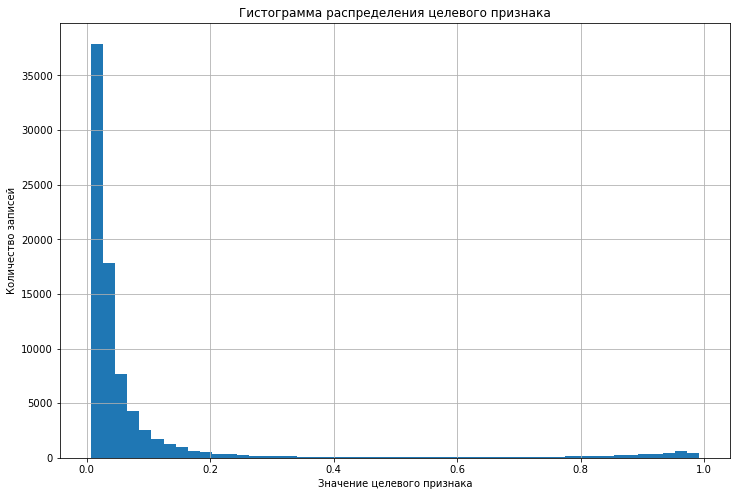

In [14]:
plt.figure(figsize=(12,8))
common['razn'].plot(kind='hist', bins=50, grid=True)
plt.title('Гистограмма распределения целевого признака')
plt.xlabel('Значение целевого признака')
plt.ylabel('Количество записей')
plt.show()

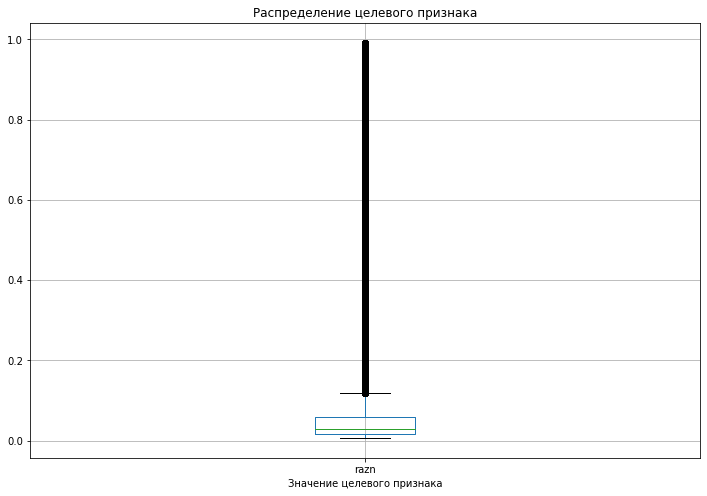

In [15]:
plt.figure(figsize=(12,8))
common['razn'].plot(kind='box', grid=True)
plt.title('Распределение целевого признака')
plt.xlabel('Значение целевого признака')
plt.show()

Распределение имеет длинный тяжелый "хвост". Диаграмма размаха также это подтверждает. Такой "хвост" будет мешать модели, нужно по возможности отнормировать распределение. Для этого возьмем натуральный логарифм таргета.
Добавим столбец log_razn с логарифмированной разницей PD - flg_90_12_add.

In [16]:
common['log_razn'] = common.apply(lambda x: np.log(np.abs(x.PD - x.flg_90_12_add)), axis=1)

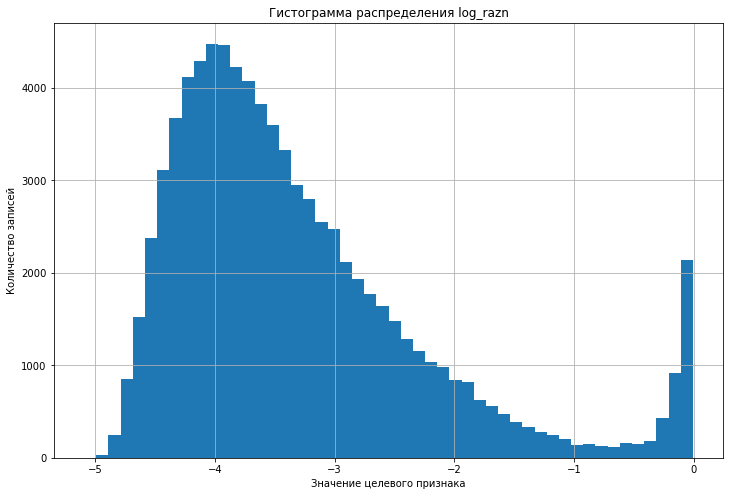

In [17]:
plt.figure(figsize=(12,8))
common['log_razn'].plot(kind='hist', bins=50, grid=True)
plt.title('Гистограмма распределения log_razn')
plt.xlabel('Значение целевого признака')
plt.ylabel('Количество записей')
plt.show()

Распределение стало больше похоже на нормальное.

Теперь выборочно рассмотрим некоторые признаки. Например, Category_Feature_2. Забегая вперед, этот признак вошел в топ наиболее важных признаков для модели.

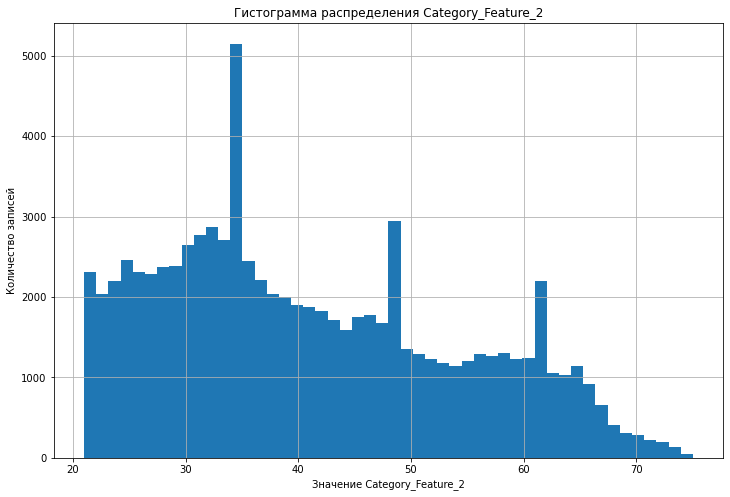

In [18]:
plt.figure(figsize=(12,8))
common['Category_Feature_2'].plot(kind='hist', bins=50, grid=True)
plt.title('Гистограмма распределения Category_Feature_2')
plt.xlabel('Значение Category_Feature_2')
plt.ylabel('Количество записей')
plt.show()

Нетрудно догадаться, что это возраст клиента. Очевидно, что он будет оказывать заметное влияние на вероятность дефолта. Наблюдаются три пика на возрасте 34, 49 и 62 года. Это распредедение также не выглядит нормальным, тоже прологарифмируем этот признак.

In [19]:
common['log_cat_feat_2'] = common.apply(lambda x: np.log(x.Category_Feature_2), axis=1)

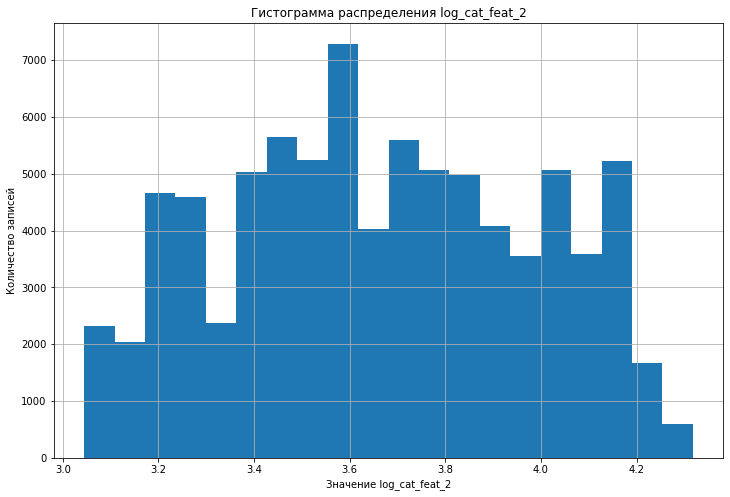

In [20]:
plt.figure(figsize=(12,8))
common['log_cat_feat_2'].plot(kind='hist', bins=20, grid=True)
plt.title('Гистограмма распределения log_cat_feat_2')
plt.xlabel('Значение log_cat_feat_2')
plt.ylabel('Количество записей')
plt.show()

Теперь нужно подумать, как заполнить пропущенные значения. Сформируем отдельно список численных столбцов и категориальных столбцов с пропусками.

In [21]:
num_cols_to_fill_1 = common.loc[:, 'Feature_0':'Feature_4']
num_cols_to_fill_2 = common.loc[:, 'Feature_55':'Feature_57']
num_cols_to_fill_3 = common.loc[:, 'Feature_69':'Feature_1882']

cat_cols_to_fill = common.loc[:, 'Category_Feature_0':'Category_Feature_18']

Пропуски в численных столбцах заполним средним значением по группе клиентов (по году и месяцу подачи заявки на кредит), в категориальных - наиболее часто встречающимся значением (модой) по каждой группе клиентов.

In [22]:
for col in num_cols_to_fill_1:
    common[col] = common[col].fillna(common.groupby('APPLICATION_MONTH')[col].transform('mean'))
    
for col in num_cols_to_fill_2:
    common[col] = common[col].fillna(common.groupby('APPLICATION_MONTH')[col].transform('mean'))
    
for col in num_cols_to_fill_3:
    common[col] = common[col].fillna(common.groupby('APPLICATION_MONTH')[col].transform('mean'))

In [23]:
for col in cat_cols_to_fill:
    common[col] = common[col].fillna(common.groupby('APPLICATION_MONTH')[col].transform(lambda x:x.mode().iat[0]))

Теперь удалим ненужные столбцы из датафрейма. Это будут: 
* flg_90_12_add - на его основе мы считали razn;
* PD - на его основе мы считали razn;
* APPLICATION_MONTH - не нужен для модели, т.к. нет привязки ко времени;
* incident - уникальный номер, тоже "шум" для модели;
* razn - разница между flg_90_12_add и PD, выбрасываем, так как создали логарифм разницы;
* Category_Feature_2 - не нужен, так как создали log_cat_feat_2.

In [24]:
common = common.drop(['flg_90_12_add', 'PD', 'APPLICATION_MONTH', 'incident', 'razn',
                      'Category_Feature_2'], axis=1)

In [25]:
common.head()

Category_Feature_0  Category_Feature_1  Category_Feature_3  \
0                 6.0                   2                 2.0   
1                 1.0                   2                 4.0   
2                 6.0                   2                 1.0   
3                 4.0                   2                 1.0   
4                 6.0                   2                 4.0   

   Category_Feature_4  Category_Feature_5  Category_Feature_6  \
0                 0.0                   3                   1   
1                 0.0                   3                   1   
2                 0.0                   3                   0   
3                 0.0                   3                   1   
4                 2.0                   3                   1   

   Category_Feature_7  Category_Feature_8  Category_Feature_9  \
0                 2.0             35000.0                 0.0   
1                 2.0             50000.0                 0.0   
2                 1.0             20000.0                 0.0   
3                 2.0             30000.0                 0.0   
4                 3.0             50000.0                 0.0   

   Category_Feature_10  Category_Feature_11  Category_Feature_12  \
0                  0.0                  1.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  1.0                  0.0   

   Category_Feature_13  Category_Feature_14  Category_Feature_15  \
0                  2.0                  7.0                  4.0   
1                  2.0                  7.0                  5.0   
2                  0.0                  7.0                  5.0   
3                  2.0                  7.0                  1.0   
4                  2.0                  7.0                  5.0   

   Category_Feature_16  Category_Feature_17  Category_Feature_18  Feature_0  \
0                 28.0                  6.0                  3.0   1.378409   
1                 23.0                  3.0                  4.0   2.457185   
2                  4.0                  4.0                  5.0   1.378409   
3                 32.0                  1.0                  4.0   2.457185   
4                 22.0                  5.0                  4.0   2.246983   

   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0   1.139337   1.123288   0.225000   0.175000          0          0   
1   1.124914   1.116355   0.333333   0.166667          0          0   
2   1.139337   1.123288   0.253165   0.253165          0          1   
3   1.124914   1.116355   0.650000   0.150000          0          0   
4   1.077166   1.143992   0.900000   0.250000          0          1   

   Feature_7  Feature_8  Feature_9  Feature_10  Feature_11  Feature_12  \
0          1          1          0           0           0           1   
1          7          1          0           0           0           4   
2         10          2          2           0           1          10   
3          0          0          0           0           0           0   
4          3          3          0           0           1           3   

   Feature_13  Feature_14  Feature_15  Feature_16  Feature_17  Feature_18  \
0           1           0           0           0           1           1   
1           1           0           0           0           3           1   
2           5           2           0           1           8           5   
3           0           0           0           0           0           0   
4           4           0           0           1           3           4   

   Feature_19  Feature_20  Feature_21  Feature_22  Feature_23  Feature_24  \
0           0           0           0           0           0           0   
1           0           0           0           

## 5. Подготовка выборок, обучение модели

Для тестовой выборки возьмем все объекты с NaN в таргете.

In [26]:
data_train = common.query('log_razn.notna()', engine='python')
data_test = common.query('log_razn.isna()', engine='python')

In [27]:
features_test = data_test.drop('log_razn', axis=1)
target_test = data_test['log_razn']

In [28]:
features_train = data_train.drop('log_razn', axis=1)
target_train = data_train['log_razn']

In [29]:
data_test.shape[0]

1000

In [30]:
data_train.shape[0]

81617

Видим, что в тестовую выборку попало 1.2% данных. Пока неясно, хорошо это или плохо. Возможно переобучение модели на большом количестве записей тренировочной выборки.

Будем применять CatBoostRegressor с подбором оптимальных гиперпараметров с помощью grid_search. Перебирать будем по сетке следующие гиперпараметры:

* learning_rate - особенно важный параметр, т.к. в случае высокого шага возможен "перескок" модели мимо локального минимума градиентного спуска, а в случае низкого шага - наоборот, модель остановится, так и не достигнув минимума;
* depth - глубина дерева. Также очень важен, так как при большой глубине дерева есть риск переобучения;
* l2_leaf_reg - регуляризация l2, помогает бороться с большими весами признаков для модели.

In [31]:
model = CatBoostRegressor(iterations=1000,
                          learning_rate=0.001,
                          verbose=False,
                          loss_function='RMSE')

grid = {'l2_leaf_reg': [1, 9, 20],
        'learning_rate': [0.001, 0.01, 0.1],
        'depth': [4, 6, 8]}

In [32]:
grid_search_result = model.grid_search(grid, 
                                       X=features_train, 
                                       y=target_train,
                                       plot=True)

model_grid = CatBoostRegressor(iterations=2000,
                          verbose=False,
                          loss_function='RMSE',
                          **grid_search_result['params'])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 1.565278304
bestIteration = 999

0:	loss: 1.5652783	best: 1.5652783 (0)	total: 1m 46s	remaining: 46m 5s

bestTest = 0.8029999145
bestIteration = 999

1:	loss: 0.8029999	best: 0.8029999 (1)	total: 3m 50s	remaining: 47m 59s

bestTest = 0.7856941309
bestIteration = 723

2:	loss: 0.7856941	best: 0.7856941 (2)	total: 5m 35s	remaining: 44m 41s

bestTest = 1.566274884
bestIteration = 999

3:	loss: 1.5662749	best: 0.7856941 (2)	total: 7m 30s	remaining: 43m 11s

bestTest = 0.8032200999
bestIteration = 999

4:	loss: 0.8032201	best: 0.7856941 (2)	total: 9m 30s	remaining: 41m 50s

bestTest = 0.784705073
bestIteration = 989

5:	loss: 0.7847051	best: 0.7847051 (5)	total: 11m 16s	remaining: 39m 26s

bestTest = 1.567870891
bestIteration = 999

6:	loss: 1.5678709	best: 0.7847051 (5)	total: 13m 11s	remaining: 37m 40s

bestTest = 0.8038085228
bestIteration = 999

7:	loss: 0.8038085	best: 0.7847051 (5)	total: 15m 13s	remaining: 36m 9s

bestTest = 0.7833553581
bestIteration = 998

8:	loss: 0.78

In [33]:
model_grid.get_params()

{'iterations': 2000,
 'learning_rate': 0.1,
 'depth': 6,
 'l2_leaf_reg': 9,
 'loss_function': 'RMSE',
 'verbose': False}

Обучаем модель с найденными гиперпараметрами:

In [35]:
model_grid.fit(features_train, target_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Сделаем таблицу важности признаков для модели:

In [36]:
feature_importance = model_grid.get_feature_importance()
top_features = pd.Series(feature_importance, index=features_test.columns).sort_values(ascending=False)
top_features = pd.DataFrame({'feature': top_features.index, 'importance': top_features.values})

top_features

,feature,importance
0,log_cat_feat_2,5.149917
1,Category_Feature_1,4.904468
2,Feature_960,4.471569
3,Feature_962,4.247989
4,Category_Feature_5,2.694897
5,Category_Feature_0,2.435289
6,Feature_1884,2.418067
7,Feature_1833,1.988368
8,Category_Feature_18,1.946458
9,Feature_1883,1.763419


Создадим список признаков нулевой важности, которые будем удалять:

In [37]:
feats_to_drop = top_features.query('importance == 0')
drop_list = feats_to_drop['feature'].tolist()

drop_list

['Feature_1607',
 'Feature_133',
 'Feature_135',
 'Feature_1386',
 'Feature_1481',
 'Feature_1483',
 'Feature_1373',
 'Feature_1459',
 'Feature_1482',
 'Feature_698',
 'Feature_1079',
 'Feature_1120',
 'Feature_1504',
 'Feature_1389',
 'Feature_1499',
 'Feature_1650',
 'Feature_1055',
 'Feature_1594',
 'Feature_1500',
 'Feature_1501',
 'Feature_1502',
 'Feature_1305',
 'Feature_1390',
 'Feature_1496',
 'Feature_1505',
 'Feature_1506',
 'Feature_1038',
 'Feature_1507',
 'Feature_189',
 'Feature_190',
 'Feature_192',
 'Feature_193',
 'Feature_1508',
 'Feature_1498',
 'Feature_1495',
 'Feature_1484',
 'Feature_151',
 'Feature_139',
 'Feature_140',
 'Feature_1114',
 'Feature_1465',
 'Feature_1099',
 'Feature_1487',
 'Feature_1488',
 'Feature_149',
 'Feature_1489',
 'Feature_152',
 'Feature_1494',
 'Feature_153',
 'Feature_154',
 'Feature_155',
 'Feature_156',
 'Feature_1387',
 'Feature_1490',
 'Feature_1458',
 'Feature_1491',
 'Feature_118',
 'Feature_119',
 'Feature_1475',
 'Feature_117',

Удалим неважные признаки из обучающей и тестовой выборок, заново обучим модель с найденными гиперпараметрами.

In [38]:
for col in drop_list:
    features_train = features_train.drop([col], axis=1)
    features_test = features_test.drop([col], axis=1)

In [39]:
model = CatBoostRegressor(iterations=2000,
                          learning_rate=0.1,
                          depth = 6,
                          l2_leaf_reg = 9,
                          verbose=False,
                          loss_function='RMSE',
                          random_seed = 20211031)

In [40]:
model.fit(features_train, target_train)

Получим предсказания на тестовой выборке:

In [41]:
pred = model.predict(features_test)

Выполним обратное преобразование логарифма нашего таргета:

In [42]:
result = pd.DataFrame({'razn_log': pred})
result['razn'] = result.apply(lambda x: np.exp(x.razn_log), axis=1)

Сохраним результат в csv:

In [43]:
result = result.drop('razn_log', axis=1)
result.to_csv('predictions_.csv', index=False, header=False)